In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from glob import iglob

# my modules
import set_config
from common_functions import create_shift_category
from common_functions import create_df_from_file

# call set_config
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_local = set_config.ConfigSectionMap("SectionOne")['local']

# %matplotlib qt 

In [16]:
#Import external data
import QlikSense_OEE
import BATCHACTIVE
import CNTR
df_changeover=BATCHACTIVE.changeover()
df_OEE=QlikSense_OEE.qs_extract_oee()
df_count = CNTR.CNTR_Files()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
# # read IP21 SPEED files for AL6 packaging machines
# # dir_IP_21 = r"C:\Users\Raza-PC\Documents\McLaren\Sanofi\Sanofi\Machine_Speed_Model\IP21_Data\Counters"
# folder = 'IP21_data'
# # path = dir_IP_21

# Files = []
# df = []
# df_count = pd.DataFrame()

# for filename in os.listdir( path ):
#     if filename.endswith('.csv'):
#         Files.append(filename)

# Files.sort(key=str.lower)

# # Loop through all the files.
# for filename in Files:
#     file_path = os.path.join(path, filename)
#     # print (filename)
#     df = pd.read_csv(file_path)
#     df['Filename'] = filename
#     df_count = df_count.append(df)


In [17]:
df_count.rename(columns={'Name':'Filename'}, inplace=True)
df_count['Filename'].value_counts()

36640901_CNTRG             1435729
36630901_CNTR_GOOD         1108570
36670901_CNTR_GOOD          931087
36650901_CNTR_OUTPUT2       230200
36680901_CNTR_GOOD           70481
36680902_CNTR_GOOD           69915
36630901_CNTRB               45671
36640901_CNTRB               18282
36670901_CNTRB               13010
36640901_FAULT               11474
36650901_CNTR_BAD_FS_F2      11157
36680901_FAULT                8409
36670901_FAULT                7623
36680902_FAULT                7423
36630901_FAULT                6803
Name: Filename, dtype: int64

In [6]:
# already done in CNTR.CNTR_Files
# # label the rows with the Machine name
# df_count['Machine'] = ''
# df_count.loc[df_count['Name'].str.contains('36630901'), 'Machine'] = 'Assembly'
# df_count.loc[df_count['Name'].str.contains('36640901'), 'Machine'] = 'Labeler'
# df_count.loc[df_count['Name'].str.contains('36650901'), 'Machine'] = 'Packaging'
# df_count.loc[df_count['Name'].str.contains('36680901'), 'Machine'] = 'Cartoner'
# df_count.loc[df_count['Name'].str.contains('36680902'), 'Machine'] = 'Palletizer'

# df_count['Type'] = ''
# df_count.loc[df_count['Name'].str.contains('CNTRG'), 'Type'] = 'Good'
# df_count.loc[df_count['Name'].str.contains('GOOD'), 'Type'] = 'Good'
# df_count.loc[df_count['Name'].str.contains('OUTPUT'), 'Type'] = 'Good'

# df_count.loc[df_count['Name'].str.contains('CNTRB'), 'Type'] = 'Bad'
# df_count.loc[df_count['Name'].str.contains('BAD'), 'Type'] = 'Bad'
# df_count.loc[df_count['Name'].str.contains('FAULT'), 'Type'] = 'Bad'


In [26]:
df_count['IP_TREND_TIME'] = pd.to_datetime(df_count['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_count=df_count.set_index('IP_TREND_TIME')
df_count = df_count.sort_index()
df_count['Production']=0

machines = ['Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer']

KeyError: 'IP_TREND_TIME'

In [21]:
df_count['units_per_sec'] = df_count['counter_diff'] / df_count['time_diff'] 

In [8]:
# take dates found in df_speed
start_date = df_count.index.min()
end_date = df_count.index.max()

daterange = pd.date_range(start = start_date, end = end_date, freq='60s')

df_model = pd.DataFrame(daterange)
df_model.rename(columns={0:'datetime'}, inplace=True)

df_model=df_model.set_index('datetime')

df_model = df_model.resample('60S').count()

In [57]:
df_palletizer=df_count[ (df_count['Machine']=='Palletizer') & (df_count['Type'] == 'Good')]
df_palletizer['Production']=df_palletizer['IP_TREND_VALUE'].diff()
df_palletizer2 = df_palletizer.resample('60S').sum()
df_palletizer3=df_palletizer2[ (df_palletizer2['Production'] != 0)]

l = len(df_palletizer3)-1
i = 0

df_palletizer4=df_palletizer3


while i < l:
    a = df_palletizer4['Production'][i+1]
    if a < 0:
        df_palletizer4['Production'][i]=1
        df_palletizer4['Production'][i+2]=-1
        i = i +3
    else:
        df_palletizer4['Production'][i]=0
        i=i+1

df_palletizer5=df_palletizer4[ (df_palletizer4['Production'] != 0)]
df_palletizer5=df_palletizer5[:-1]
df_palletizer6=df_palletizer5[ (df_palletizer5['Production'] >= -1)]
a=df_palletizer6[ (df_palletizer6['Production'] == 1)]
b=df_palletizer6[ (df_palletizer6['Production'] == -1)]

df_pchangeover=pd.DataFrame(columns=['start','end'])
df_pchangeover['start']=a.index
df_pchangeover['end']=b.index

c=df_palletizer5[ (df_palletizer5['Production'] < -1)]['Production']
df_pchangeover['Duration']=df_pchangeover['end']-df_pchangeover['start']
df_pchangeover['Size']=(c.values*-1)
df_pchangeover['Production_Time']=df_pchangeover['start']-df_pchangeover['start'].shift(1)


<ipython-input-57-820e9be2d165>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_palletizer['Production']=df_palletizer['IP_TREND_VALUE'].diff()
<ipython-input-57-820e9be2d165>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_palletizer4['Production'][i]=0
C:\Users\mark_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [9]:
for x in machines:
    
    i = 0
    j=0
    df_good = df_count.loc[(df_count['Machine']==x) & (df_count['Type']=='Good') ]
    df_bad = df_count.loc[(df_count['Machine']==x) & (df_count['Type']=='Bad') ]
    
    df_good['Production']=df_good['IP_TREND_VALUE'].diff()
    
    df_bad['Production']=df_bad['IP_TREND_VALUE'].diff()
            
    df_good['Production'][df_good['Production'] < 0] = 0
    df_bad['Production'][df_bad['Production'] < 0] = 0
    
    df_good_min = df_good.resample('60S').sum()
    df_bad_min = df_bad.resample('60S').sum()
    
    df_model['{}_Good'.format(x)]=df_good_min['Production']
    df_model['{}_Bad'.format(x)]=df_bad_min['Production']
            
            
    
    

<ipython-input-9-052594ebeb69>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['Production']=df_good['IP_TREND_VALUE'].diff()
<ipython-input-9-052594ebeb69>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bad['Production']=df_bad['IP_TREND_VALUE'].diff()
<ipython-input-9-052594ebeb69>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [59]:
# get the packaging DESIGNATION file which shows the pcs format
folder = 'IP21_data'
# path = r"C:\Users\Raza-PC\Documents\McLaren\Sanofi\Sanofi\Machine_Speed_Model\IP21_Data"

# Files = []
# df_designation = pd.DataFrame()

# for filename in os.listdir( path ):
#     if filename.endswith('36650901_DESIGNATION.csv'):      
#         file_path = os.path.join(path, filename)
#         # print (filename)
#         df_designation = pd.read_csv(file_path)
#         df_designation['Filename'] = filename

df_designation = create_df_from_file(dir_sanofi_share, 'IP21_Data', 'DESIGNATION')

# just keep the Good QLEVEL and VALUEs like 'FS...'
df_designation = df_designation[(df_designation.IP_TREND_QLEVEL == 'Good') & (df_designation.IP_TREND_VALUE.str.contains('FS'))]

df_designation['N']=0
df_designation.loc[df_designation['IP_TREND_VALUE'].str.contains('5'), 'N'] = 5
df_designation.loc[df_designation['IP_TREND_VALUE'].str.contains('3'), 'N'] = 3

df_designation['IP_TREND_TIME'] = pd.to_datetime(df_designation['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_designation=df_designation.set_index('IP_TREND_TIME')

#Assign number of pens per package
df_model['N']=df_designation.resample('60S').sum()['N']
df_model['N']=df_model['N'].fillna(0)
df_model['N']=df_model['N'].replace(to_replace=0, method='ffill')
df_model['N']=df_model['N'].replace(0, 3)


# df_designation = create_df_from_file(dir_sanofi_share, 'IP21_Data', 'DESIGNATION')
# df_designation['IP_TREND_TIME'] = pd.to_datetime(df_designation['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
# df_designation = df_designation.sort_values('IP_TREND_TIME')
# # drop NaN IP_TREND_VALUE 
# df_designation.dropna(subset=['IP_TREND_VALUE'], inplace=True)
# df_designation.loc[df_designation['IP_TREND_VALUE'].str.contains('5'), 'Format'] = df_designation.loc[df_designation['IP_TREND_VALUE'].str.contains('5'), 'Format'] = 5
# df_designation.loc[df_designation['IP_TREND_VALUE'].str.contains('3'), 'Format'] = df_designation.loc[df_designation['IP_TREND_VALUE'].str.contains('3'), 'Format'] = 3
# # backward fill any missing Format - could only see Umstellprogramm (Changeover program) so think changeover had begun
# df_designation.bfill(inplace=True)
# df_designation


In [60]:
#Define number of pens per carton
npc=40

#Convert cartoner and palletizer units to pens
df_model['Cartoner_Good']=df_model['Cartoner_Good']*npc*df_model['N']
df_model['Cartoner_Bad']=df_model['Cartoner_Bad']*npc*df_model['N']

df_model['Palletizer_Good']=df_model['Palletizer_Good']*npc*df_model['N']
df_model['Palletizer_Bad']=df_model['Palletizer_Bad']*npc*df_model['N']

In [61]:
#Define state, where 1 is production and 0 is a break/changeover.
df_model['State']=1
df_model['Average_Good']= (df_model['Assembly_Good'] + df_model['Labeler_Good'] + df_model['Packaging_Good'] + df_model['Cartoner_Good'] + df_model['Palletizer_Good'])/5
df_model['Average_Bad']= (df_model['Assembly_Bad'] + df_model['Labeler_Bad'] + df_model['Packaging_Bad'] + df_model['Cartoner_Bad'] + df_model['Palletizer_Bad'])/5

#Identify a break by a specified break threshold minute pause in production.
bt=30
#Identify a pens per minute threshold, where if this number of pens is produced on average, production has resumed.
mt=50

df_model['Rolling_Avg']=df_model['Assembly_Good'].rolling(min_periods=1, window=bt).sum()
#df_model['Rolling_Avg']=df_model['Palletizer_Good'].rolling(min_periods=1, window=bt).sum()
df_model.loc[df_model['Rolling_Avg']<mt,'State']=0

#Identify changes in state. -1 indicates a break starting, +1 indicates a break ending
df_model['State_Change']=df_model['State']-df_model['State'].shift(+1)

df_model['State_Change']=((df_model['State_Change'].shift(1-bt))*10) + df_model['State_Change']
df_model['State_Change']=df_model['State_Change'].replace(-1,0)
df_model['State_Change']=df_model['State_Change'].replace(-9,0)
df_model['State_Change']=df_model['State_Change'].replace(10,0)
df_model['State_Change']=df_model['State_Change'].replace(1,10)
df_model['State']=df_model['State_Change'].replace(to_replace=0, method='ffill')

df_model['Availability']=(df_model['State']+10)*0.05
    

In [63]:
#Calculate cumulative totals for good/bad and potential pens made. Resets at each production break.
#Maximum pens depends on format - 450 (3 pens) or 500 (5 pens)
max_pens_minute=512

for y in machines:
    i=0
    df_model['{}_Potential_Pens'.format(y)]=0
    df_model['{}_Total_Pens'.format(y)]=0
    df_model['{}_Total_Bad_Pens'.format(y)]=0
    for x in df_model.index:
        if ((df_model['State'][x]==10) & (i>0)):
            df_model['{}_Potential_Pens'.format(y)][x]=(df_model['{}_Potential_Pens'.format(y)].shift(+1)[x])+512
            df_model['{}_Total_Pens'.format(y)][x]=(df_model['{}_Total_Pens'.format(y)].shift(+1)[x])+df_model['{}_Good'.format(y)][x]
            df_model['{}_Total_Bad_Pens'.format(y)][x]=(df_model['{}_Total_Bad_Pens'.format(y)].shift(+1)[x])+df_model['{}_Bad'.format(y)][x]
            i=i+1

        else:
            i=i+1
            
    #df_model['{}_Pen_Performance'.format(y)]=df_model['{}_Total_Pens'.format(y)]/df_model['{}_Potential_Pens'.format(y)]
    #df_model['{}_Pen_Quality'.format(y)]=1-(df_model['{}_Total_Bad_Pens'.format(y)]/df_model['{}_Total_Pens'.format(y)])
    #df_model['{}_OEE'.format(y)]=df_model['{}_Pen_Performance'.format(y)]* df_model['{}_Pen_Quality'.format(y)]
    
    df_model['{}_Pen_Performance'.format(y)]=(df_model['{}_Good'.format(y)])/ max_pens_minute
    df_model['{}_Pen_Quality'.format(y)]=1-(df_model['{}_Bad'.format(y)]/df_model['{}_Good'.format(y)])
    df_model['{}_OEE'.format(y)]=df_model['{}_Pen_Performance'.format(y)]* df_model['{}_Pen_Quality'.format(y)]
    
df_model=df_model.fillna(0)

<ipython-input-63-42051a6b22f2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['{}_Potential_Pens'.format(y)][x]=(df_model['{}_Potential_Pens'.format(y)].shift(+1)[x])+512
<ipython-input-63-42051a6b22f2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['{}_Total_Pens'.format(y)][x]=(df_model['{}_Total_Pens'.format(y)].shift(+1)[x])+df_model['{}_Good'.format(y)][x]
<ipython-input-63-42051a6b22f2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [64]:
#Define future time to look at
ft=30

df_shift=df_model.shift(-ft)
df_model['Start_Type']=10
df_model['Clean_Start']=10
df_model['Dirty_Start']=10
df_model['Complete_Start']=10
df_model['Incomplete_Start']=10
for x in df_model.index:
    if df_model['State_Change'][x]==10:
        a=df_shift['Assembly_Total_Pens'][x]
        b=df_shift['Labeler_Total_Pens'][x]
        c=df_shift['Packaging_Total_Pens'][x]
        d=df_shift['Cartoner_Total_Pens'][x]
        e=df_shift['Palletizer_Total_Pens'][x]
        
        clean = a>=b>=c>=d>=e
        
        if clean==True:
            df_model['Start_Type'][x]=2
            df_model['Clean_Start'][x]=1
            
        else:
            df_model['Start_Type'][x]=1
            df_model['Dirty_Start'][x]=1
            
        if e>0:
            df_model['Complete_Start'][x]=1
        else:
            df_model['Incomplete_Start'][x]=1
            
#df_model['Start_Type']=df_model['Start_Type'].replace(to_replace='', method='ffill')
df_model.loc[df_model['State_Change']==-10, 'Start_Type'] = 0
df_model.loc[df_model['State_Change']==-10, 'Clean_Start'] = 0
df_model.loc[df_model['State_Change']==-10, 'Dirty_Start'] = 0
df_model.loc[df_model['State_Change']==-10, 'Complete_Start'] = 0
df_model.loc[df_model['State_Change']==-10, 'Incomplete_Start'] = 0
df_model['Start_Type']=df_model['Start_Type'].replace(to_replace=10, method='ffill')
df_model['Clean_Start']=df_model['Clean_Start'].replace(to_replace=10, method='ffill')
df_model['Dirty_Start']=df_model['Dirty_Start'].replace(to_replace=10, method='ffill')
df_model['Complete_Start']=df_model['Complete_Start'].replace(to_replace=10, method='ffill')
df_model['Incomplete_Start']=df_model['Incomplete_Start'].replace(to_replace=10, method='ffill')

<ipython-input-64-0d3aae2c3935>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Start_Type'][x]=1
<ipython-input-64-0d3aae2c3935>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Dirty_Start'][x]=1
<ipython-input-64-0d3aae2c3935>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Complete_Start'][x]=1
<ipython-input-64-0d3aae2c3935>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [65]:
#Create correlation matrix between machines
df_correlation = pd.DataFrame(df_model,columns=['Assembly_Good','Labeler_Good','Packaging_Good','Cartoner_Good','Palletizer_Good'])
matrix=df_correlation.corr()

In [66]:
#Calculate buffer between lines
df_model['Assembly_Buffer']=0
df_model['Labeler_Buffer']=df_model['Assembly_Total_Pens']-df_model['Labeler_Total_Pens']
df_model['Packaging_Buffer']=df_model['Labeler_Total_Pens']-df_model['Packaging_Total_Pens']
df_model['Cartoner_Buffer']=df_model['Packaging_Total_Pens']-df_model['Cartoner_Total_Pens']
df_model['Palletizer_Buffer']=df_model['Cartoner_Total_Pens']-df_model['Palletizer_Total_Pens']

In [67]:
#Create models with different time grouping
df_model_10min=df_model.groupby([pd.Grouper(freq='10min')]).mean()
df_model_hourly=df_model.groupby([pd.Grouper(freq='60min')]).mean()
df_model_daily=df_model.groupby([pd.Grouper(freq='1D')]).mean()

In [68]:
#Manually created dataframe based on Marcel's Changeover times
mstart = [datetime.datetime(2021, 8, 2, 21, 45), datetime.datetime(2021, 8, 3, 19, 0),datetime.datetime(2021, 8, 4, 0, 20),datetime.datetime(2021, 8, 4, 6, 30),datetime.datetime(2021, 8, 5, 19, 20),datetime.datetime(2021, 8, 6, 0, 20),datetime.datetime(2021, 8, 6, 9, 0),datetime.datetime(2021, 8, 7, 1, 45),datetime.datetime(2021, 8, 10, 9, 10),datetime.datetime(2021, 8, 12, 10, 10),datetime.datetime(2021, 8, 12, 16, 0)]
mend = [datetime.datetime(2021, 8, 2, 23, 30), datetime.datetime(2021, 8, 3, 21, 15),datetime.datetime(2021, 8, 4, 2, 5),datetime.datetime(2021, 8, 4, 7, 20),datetime.datetime(2021, 8, 5, 20, 45),datetime.datetime(2021, 8, 6, 3, 20),datetime.datetime(2021, 8, 6, 12, 55),datetime.datetime(2021, 8, 7, 3, 45),datetime.datetime(2021, 8, 10, 10, 55),datetime.datetime(2021, 8, 12, 11, 0),datetime.datetime(2021, 8, 12, 20, 0)]
df_mchangeover=pd.DataFrame(columns=['start','end'])
df_mchangeover['start']=mstart
df_mchangeover['end']=mend

In [69]:
#Readin in OEE from Clicksense files as convert from shift based OEE to daily OEE. To do this OEE is 'weighted' by how many hours in a day it is.
df_OEE['Weighted']=df_OEE['OEE %']*df_OEE['Net Opening Time']
df_OEE_daily=df_OEE.resample('1D').sum()
df_OEE_daily['Weighted_OEE']=df_OEE_daily['Weighted']/df_OEE_daily['Net Opening Time']

In [38]:
#Identify all types of starts in a separate column

#Complete Clean Start
df_model['CC_Start']=0
df_model.loc[ (df_model['Clean_Start']==1) & (df_model['Complete_Start']==1) , 'CC_Start'] = 1

#Complete Dirty Start
df_model['CD_Start']=0
df_model.loc[ (df_model['Dirty_Start']==1) & (df_model['Complete_Start']==1) , 'CD_Start'] = 1

#Incomplete Clean Start
df_model['IC_Start']=0
df_model.loc[ (df_model['Clean_Start']==1) & (df_model['Incomplete_Start']==1) , 'IC_Start'] = 1

#Incomplete Dirty Start
df_model['ID_Start']=0
df_model.loc[ (df_model['Dirty_Start']==1) & (df_model['Incomplete_Start']==1) , 'ID_Start'] = 1

In [39]:
#BELOW ONWARDS ARE ALL DISPLAYS, GRAPHS OR TABLES.

In [99]:
# data = df_count[(df_count.Machine == 'Packaging') & (df_count.Filename == '36650901_CNTR_OUTPUT2')]
# data[data>1000]
# 2021-09-23 01:45:00
date = df_count.loc['2021-09-23']
time = date.between_time('01:40','01:50')
time

,Filename,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Machine,Type,counter_diff,time_diff,Production,units_per_sec,Percentile_Rank
IP_TREND_TIME,,,,,,,,,,,
2021-09-23 01:40:16.300,36650901_CNTR_OUTPUT2,50787,Good,Good,Packaging,Good,0.0,599.4,0,0.000000,0.016961
2021-09-23 01:40:35.800,36680902_FAULT,0,Good,Good,Palletizer,Bad,0.0,599.3,0,0.000000,0.064692
2021-09-23 01:41:11.600,36670901_FAULT,0,Good,Good,Packaging2,Bad,0.0,599.2,0,0.000000,0.007820
2021-09-23 01:41:22.800,36630901_CNTRB,3,Good,Good,Assembly,Bad,0.0,599.1,0,0.000000,0.005741
2021-09-23 01:41:40.100,36630901_CNTR_GOOD,93,Good,Good,Assembly,Good,0.0,599.9,0,0.000000,0.005741
2021-09-23 01:43:11.000,36650901_CNTR_OUTPUT2,50787,Good,Good,Packaging,Good,0.0,174.7,0,0.000000,0.016961
2021-09-23 01:43:11.000,36650901_CNTR_BAD_FS_F2,89,Good,Good,Packaging,Bad,0.0,231.1,0,0.000000,0.016961
2021-09-23 01:43:12.000,36650901_CNTR_BAD_FS_F2,89,Bad,Bad,Packaging,Bad,0.0,1.0,0,0.000000,0.016961
2021-09-23 01:43:12.000,36650901_CNTR_OUTPUT2,50787,Bad,Bad,Packaging,Good,0.0,1.0,0,0.000000,0.016961


In [69]:
# drop rows with >1000 counter_diff = dodgy data
df_count = df_count.drop(df_count[df_count.units_per_sec >1000].index)

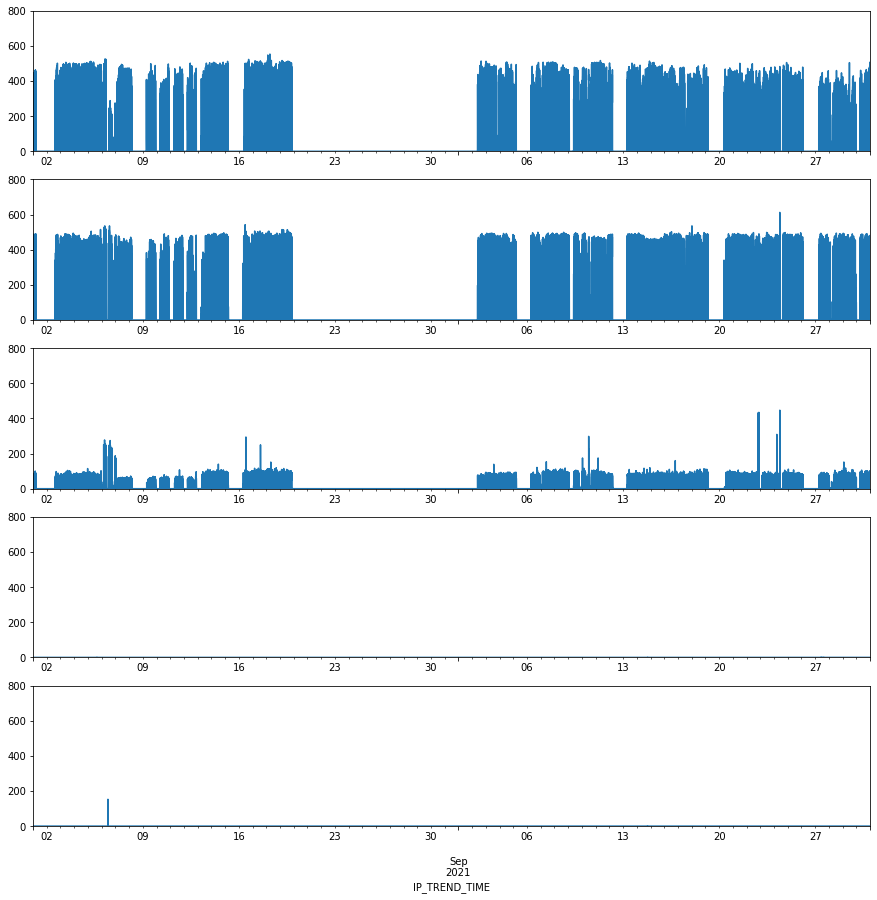

In [72]:
fig, axs = plt.subplots(len(machines), 1, figsize=(15, 15))

i=0

for m in machines:
    
    data = df_count['units_per_sec'][(df_count.Machine == m) & (df_count.Type=='Good')].resample('60s').sum()
    data.plot(ax=axs[i])
    axs[i].set_ylim(0,800)
    axs[i].set_title(m)
    i+=1

# df_count

In [75]:
df_count['Percentile_Rank'] = df_count.groupby('Machine')['counter_diff'].rank(pct=True)

In [125]:
df_count[df_count['Percentile_Rank']<.9].groupby('Machine')['counter_diff'].max()

Machine
Assembly      14.0
Cartoner       1.0
Labeler        9.0
Packaging     55.0
Packaging2     4.0
Palletizer     1.0
Name: counter_diff, dtype: float64

In [126]:
df_model['Percentile_Rank'] = df_model[df_model['Assembly_Good']<1000]['Assembly_Good'].rank(pct=True)

In [124]:
# df_model[df_model.Percentile_Rank <=.9].filter(regex='Good').max()
# df_model[df_model['Packaging_Good']>60000]
cols = ['Assembly_Good','Labeler_Good','Packaging_Good','Cartoner_Good','Palletizer_Good']

df_model[(df_model[cols] > 10000).any(axis=1)]


,Assembly_Good,Assembly_Bad,Labeler_Good,Labeler_Bad,Packaging_Good,Packaging_Bad,Cartoner_Good,Cartoner_Bad,Palletizer_Good,Palletizer_Bad,Percentile_Rank
datetime,,,,,,,,,,,
2021-09-02 09:33:00,17391.0,0.0,18951.0,317.0,18090.0,0.0,1524.0,0.0,1508.0,0.0,NaN
2021-09-09 09:30:00,133586.0,782.0,133683.0,780.0,133450.0,70.0,671.0,0.0,669.0,0.0,NaN
2021-09-23 01:45:00,0.0,0.0,0.0,0.0,69366.0,96.0,0.0,0.0,0.0,0.0,0.327747


In [100]:
date = df_model.loc['2021-09-23']
time = date.between_time('01:40','01:50')
time

,Assembly_Good,Assembly_Bad,Labeler_Good,Labeler_Bad,Packaging_Good,Packaging_Bad,Cartoner_Good,Cartoner_Bad,Palletizer_Good,Palletizer_Bad,Percentile_Rank
datetime,,,,,,,,,,,
2021-09-23 01:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327747
2021-09-23 01:41:00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327747
2021-09-23 01:42:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327747
2021-09-23 01:43:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327747
2021-09-23 01:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327747
2021-09-23 01:45:00,0.0,0.0,0.0,0.0,69366.0,96.0,0.0,0.0,0.0,0.0,0.327747
2021-09-23 01:46:00,0.0,0.0,0.0,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327747
2021-09-23 01:47:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.327747
2021-09-23 01:48:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.327747


In [138]:
df_pchangeover

,start,end,Duration,Size,Production_Time
0,2021-08-02 21:41:00,2021-08-02 23:33:00,0 days 01:52:00,1871.0,NaT
1,2021-08-03 18:53:00,2021-08-03 21:08:00,0 days 02:15:00,1954.0,0 days 21:12:00
2,2021-08-04 00:14:00,2021-08-04 02:05:00,0 days 01:51:00,303.0,0 days 05:21:00
3,2021-08-04 06:05:00,2021-08-04 07:37:00,0 days 01:32:00,380.0,0 days 05:51:00
4,2021-08-05 19:11:00,2021-08-05 20:50:00,0 days 01:39:00,3501.0,1 days 13:06:00
5,2021-08-05 23:27:00,2021-08-06 03:04:00,0 days 03:37:00,256.0,0 days 04:16:00
6,2021-08-06 11:04:00,2021-08-06 12:55:00,0 days 01:51:00,505.0,0 days 11:37:00
7,2021-08-07 01:39:00,2021-08-07 03:10:00,0 days 01:31:00,445.0,0 days 14:35:00
8,2021-08-10 09:05:00,2021-08-10 10:49:00,0 days 01:44:00,3648.0,3 days 07:26:00
9,2021-08-12 10:06:00,2021-08-12 11:01:00,0 days 00:55:00,2508.0,2 days 01:01:00


In [127]:
matrix

NameError: name 'matrix' is not defined

In [43]:
#Create new column changeover, which is 1 when a changeover is undergoing (based on palletizer counts)
df_model['Changeover']=0
for x in range ((len(df_pchangeover)-1)):
    df_model.loc[(df_model.index>=df_pchangeover.iloc[x]['start']) & (df_model.index<=df_pchangeover.iloc[x]['end'])  , 'Changeover'] = 1
df_model['Changeover'].plot()

<AxesSubplot:xlabel='datetime'>

In [44]:
#Calculate Daily Changeover time and add to daily model
sum_changeovers=df_model['Changeover'].resample('1D').sum()
df_model_daily['Daily_Changeover']=sum_changeovers
df_model_daily['Daily_Changeover_Loss']=df_model_daily['Daily_Changeover']/ (60*24/100)
df_model_daily['Daily_Changeover_Loss']

#Add daily metrics for OEE breakdown
df_model_daily['OEE_Loss']=100*(1-df_model_daily['Palletizer_OEE'])
df_model_daily['Production_Time']=(df_model_daily['State']+10)*5
df_model_daily['Production_Time_Loss']=100-df_model_daily['Production_Time']
df_model_daily['Quality_Loss']=100*df_model_daily['Average_Bad']/df_model_daily['Average_Good']
df_model_daily['Machine_Loss']=df_model_daily['OEE_Loss']-df_model_daily['Quality_Loss']-df_model_daily['Production_Time_Loss']-df_model_daily['Daily_Changeover_Loss']

In [45]:
#Create separate dataframe for daily metrics
df_daily_metrics=pd.DataFrame()
df_daily_metrics['OEE_Loss']=df_model_daily['OEE_Loss']
df_daily_metrics['MachineSpeed']=df_model_daily['Machine_Loss']
df_daily_metrics['Production']=df_model_daily['Production_Time_Loss']
df_daily_metrics['Changeover']=df_model_daily['Daily_Changeover_Loss']
df_daily_metrics['Quality']=df_model_daily['Quality_Loss']

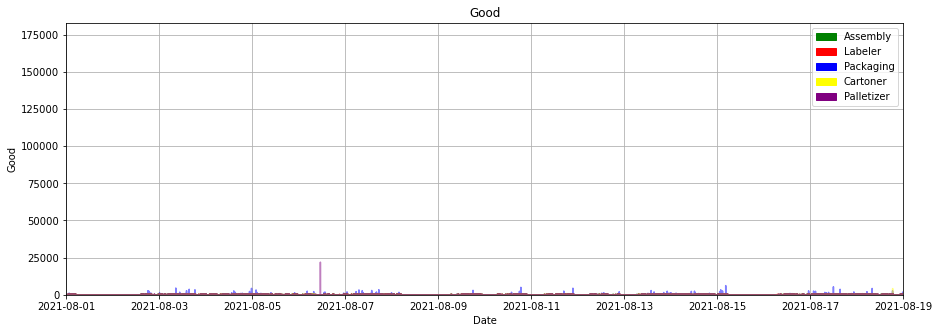

In [147]:
#Plot of good pens produced for each machine


start = datetime.datetime(2021, 8, 1)
end = datetime.datetime(2021, 8, 19)

variable='Good'

xdata=df_model.index
ydata=df_model['Assembly_{}'.format(variable)]
ydata2=df_model['Labeler_{}'.format(variable)]
ydata3=df_model['Packaging_{}'.format(variable)]
ydata4=df_model['Cartoner_{}'.format(variable)]
ydata5=df_model['Palletizer_{}'.format(variable)]

fig = plt.figure(figsize=[15,5])
ax = plt.subplot(111)

# set properties
ax.set_xlabel('Date')
ax.set_ylabel('{}'.format(variable))
ax.set_title('{}'.format(variable))

# set the limits
ax.set_xlim([start, end])
ax.set_ylim(0,max(ydata.max(),ydata2.max(),ydata3.max(),ydata4.max(),ydata5.max()))

# set the grid on
ax.grid('on')

c1 = 'green'
c2 = 'red'
c3 = 'blue'
c4 = 'yellow'
c5 = 'purple'
    
l = ax.plot(xdata, ydata,color=c1,alpha=0.5)
l = ax.plot(xdata, ydata2,color=c2,alpha=0.5)
l = ax.plot(xdata, ydata3,color=c3,alpha=0.5)
l = ax.plot(xdata, ydata4,color=c4,alpha=0.5)
l = ax.plot(xdata, ydata5,color=c5,alpha=0.5)

patch1 = mpatches.Patch(color=c1, label='Assembly')
patch2 = mpatches.Patch(color=c2, label='Labeler')
patch3 = mpatches.Patch(color=c3, label='Packaging')
patch4 = mpatches.Patch(color=c4, label='Cartoner')
patch5 = mpatches.Patch(color=c5, label='Palletizer')
plt.legend(handles=[patch1,patch2,patch3,patch4,patch5])

In [47]:
#Plot breakdown of OEE losses for a single day. Modify day variable to select date.

day=5

df_temp=df_daily_metrics.iloc[day-1]

fig = plt.figure(figsize=[15,10])
ax = plt.subplot(111)

# set properties
ax.set_xlabel('%')
ax.set_ylabel('Type of Loss')
ax.set_title('Breakdown of OEE losses for {}'.format(df_temp.name))

# set the limits
#ax.set_xlim([start, end])
#ax.set_ylim(0,100)

# set the grid on
ax.grid('on')

c1 = 'green'
c2 = 'red'
c3 = 'blue'
c4 = 'yellow'
c5 = 'purple'
    
df_temp.plot.barh()

<AxesSubplot:title={'center':'Breakdown of OEE losses for 2021-08-05 00:00:00'}, xlabel='%', ylabel='Type of Loss'>

In [48]:
#Plot clean and dirty starts alongside all changeover types

start = datetime.datetime(2021, 8, 1)
end = datetime.datetime(2021, 8, 19)

variable='Clean_Start'
variable2='Dirty_Start'

xdata=df_model.index
ydata=df_model['{}'.format(variable)]
ydata2=df_model['{}'.format(variable2)]

fig = plt.figure(figsize=[15,5])
ax = plt.subplot(111)

# set properties
ax.set_xlabel('Date')
ax.set_ylabel('{}'.format(variable))
ax.set_title('Starts')

# set the limits
ax.set_xlim([start, end])
#ax.set_ylim(0,ydata.max())
ax.set_ylim(-0.1,1.1)

# set the grid on
ax.grid('on')

c1 = 'blue'
c2 = 'red'
c3 = 'green'
c4 = 'purple'
c5='yellow'
    
l = ax.plot(xdata, ydata,color=c1,alpha=1)
l = ax.plot(xdata, ydata2,color=c2,alpha=1)

for x in range ((len(df_changeover)-1)):
        ax.axvspan(df_changeover['start'][x],df_changeover['end'][x], color=c3, alpha=0.3)
        
for x in range ((len(df_mchangeover)-1)):
        ax.axvspan(df_mchangeover['start'][x],df_mchangeover['end'][x], color=c4, alpha=0.3)
        
for x in range ((len(df_pchangeover)-1)):
        ax.axvspan(df_pchangeover['start'][x],df_pchangeover['end'][x], color=c5, alpha=0.3)

patch1 = mpatches.Patch(color=c1, label='Clean')
patch2 = mpatches.Patch(color=c2, label='Dirty')
patch3 = mpatches.Patch(color=c3, label='Changeover_Tags')
patch4 = mpatches.Patch(color=c4, label='Marcel_Changeover')
patch5 = mpatches.Patch(color=c5, label='Palletizer Changeover')
plt.legend(handles=[patch1,patch2,patch3,patch4,patch5])

In [30]:
#Plot McLaren OEE vs QlikSense OEE

start = datetime.datetime(2021, 8, 1)
end = datetime.datetime(2021, 8, 19)

variable='OEE'

xdata=df_model_daily.index
ydata=df_model_daily['Palletizer_{}'.format(variable)]
xdata2=df_OEE_daily.index
ydata2=df_OEE_daily['Weighted_OEE']

fig = plt.figure(figsize=[15,5])
ax = plt.subplot(111)

# set properties
ax.set_xlabel('Date')
ax.set_ylabel('{}'.format(variable))
ax.set_title('{}'.format(variable))

# set the limits
ax.set_xlim([start, end])
ax.set_ylim(0,max(ydata.max(),ydata2.max()))

# set the grid on
ax.grid('on')

c1 = 'green'
c2 = 'red'
c3 = 'blue'
c4 = 'yellow'
c5 = 'purple'
    
l = ax.plot(xdata, ydata,color=c1,alpha=0.5)
l = ax.plot(xdata2, ydata2,color=c2,alpha=0.5)

patch1 = mpatches.Patch(color=c1, label='McLaren Model')
patch2 = mpatches.Patch(color=c2, label='QlikSense')
plt.legend(handles=[patch1,patch2])

In [31]:
#Show all start types on one chart

start = datetime.datetime(2021, 8, 1)
end = datetime.datetime(2021, 8, 19)

variable='Clean_Start'
variable2='Dirty_Start'
variable3='Complete_Start'
variable4='Incomplete_Start'

xdata=df_model.index
ydata=df_model['{}'.format(variable)]
ydata2=df_model['{}'.format(variable2)]
ydata3=df_model['{}'.format(variable3)]
ydata4=df_model['{}'.format(variable4)]

fig = plt.figure(figsize=[15,5])
ax = plt.subplot(111)

# set properties
ax.set_xlabel('Date')
ax.set_ylabel('{}'.format(variable))
ax.set_title('Starts')

# set the limits
ax.set_xlim([start, end])
#ax.set_ylim(0,ydata.max())
ax.set_ylim(-0.1,1.1)

# set the grid on
ax.grid('on')

c1 = 'blue'
c2 = 'red'
c3 = 'green'
c4 = 'purple'
c5='yellow'
    
l = ax.plot(xdata, ydata,color=c1,alpha=0.5)
l = ax.plot(xdata, ydata2,color=c2,alpha=0.5)
l = ax.plot(xdata, ydata3,color=c3,alpha=0.5)
l = ax.plot(xdata, ydata4,color=c4,alpha=0.5)

#for x in range ((len(df_changeover)-1)):
#        ax.axvspan(df_changeover['start'][x],df_changeover['end'][x], color=c3, alpha=0.3)
        
#for x in range ((len(df_mchangeover)-1)):
#        ax.axvspan(df_mchangeover['start'][x],df_mchangeover['end'][x], color=c4, alpha=0.3)
        
for x in range ((len(df_pchangeover)-1)):
        ax.axvspan(df_pchangeover['start'][x],df_pchangeover['end'][x], color=c5, alpha=0.3)

patch1 = mpatches.Patch(color=c1, label='Clean')
patch2 = mpatches.Patch(color=c2, label='Dirty')
patch3 = mpatches.Patch(color=c3, label='Complete')
patch4 = mpatches.Patch(color=c4, label='Incomplete')
patch5 = mpatches.Patch(color=c5, label='Changeover')
plt.legend(handles=[patch1,patch2,patch3,patch4,patch5])

In [49]:
#Plot one complex start type (Complete and Clean here)

start = datetime.datetime(2021, 8, 1)
end = datetime.datetime(2021, 8, 19)

xdata=df_model.index
ydata=df_model['CC_Start']


fig = plt.figure(figsize=[15,5])
ax = plt.subplot(111)

# set properties
ax.set_xlabel('Date')
ax.set_ylabel('{}'.format(variable))
ax.set_title('Starts')

# set the limits
ax.set_xlim([start, end])
#ax.set_ylim(0,ydata.max())
ax.set_ylim(-0.1,1.1)

# set the grid on
ax.grid('on')

c1 = 'blue'
c2 = 'red'
c3 = 'green'
c4 = 'purple'
c5='yellow'
    
l = ax.plot(xdata, ydata,color=c1,alpha=1)
#l = ax.plot(xdata, ydata2,color=c2,alpha=0.0)
#l = ax.plot(xdata, ydata3,color=c3,alpha=0.5)
#l = ax.plot(xdata, ydata4,color=c4,alpha=0.0)

#for x in range ((len(df_changeover)-1)):
#        ax.axvspan(df_changeover['start'][x],df_changeover['end'][x], color=c3, alpha=0.3)
        
#for x in range ((len(df_mchangeover)-1)):
#        ax.axvspan(df_mchangeover['start'][x],df_mchangeover['end'][x], color=c4, alpha=0.3)
        
for x in range ((len(df_pchangeover)-1)):
        ax.axvspan(df_pchangeover['start'][x],df_pchangeover['end'][x], color=c5, alpha=0.3)

patch1 = mpatches.Patch(color=c1, label='Complete')
#patch2 = mpatches.Patch(color=c2, label='Dirty')
#patch3 = mpatches.Patch(color=c3, label='Complete')
#patch4 = mpatches.Patch(color=c4, label='Incomplete')
patch5 = mpatches.Patch(color=c5, label='Palletizer Changeover')
plt.legend(handles=[patch1,patch5])